<a href="https://colab.research.google.com/github/isaacdono/ml-studies/blob/main/deep%20learning/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo Prático sobre Redes Neurais Recorrentes (RNNs)

Bem-vindo a este guia prático sobre RNNs!

As **Redes Neurais Recorrentes** são especializadas em processar **dados sequenciais**, como séries temporais, texto ou áudio. Sua principal característica é possuir uma "memória" interna (um loop), que permite que informações de passos anteriores persistam e influenciem as saídas futuras.

Neste notebook, vamos:
1.  **Gerar Dados:** Criar uma série temporal simples (uma onda senoidal).
2.  **Pré-processar os Dados:** Preparar os dados para o formato que a RNN espera.
3.  **Construir uma RNN Simples:** Usaremos `SimpleRNN` do Keras para prever o próximo ponto da sequência.
4.  **Construir uma LSTM:** Implementaremos uma `LSTM` (Long Short-Term Memory), uma RNN mais avançada que lida melhor com dependências de longo prazo.
5.  **Avaliar e Comparar:** Visualizaremos as previsões de ambos os modelos para entender seu desempenho.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

print(f"TensorFlow versão: {tf.__version__}")
print("Bibliotecas importadas com sucesso!")


TensorFlow versão: 2.19.0
Bibliotecas importadas com sucesso!


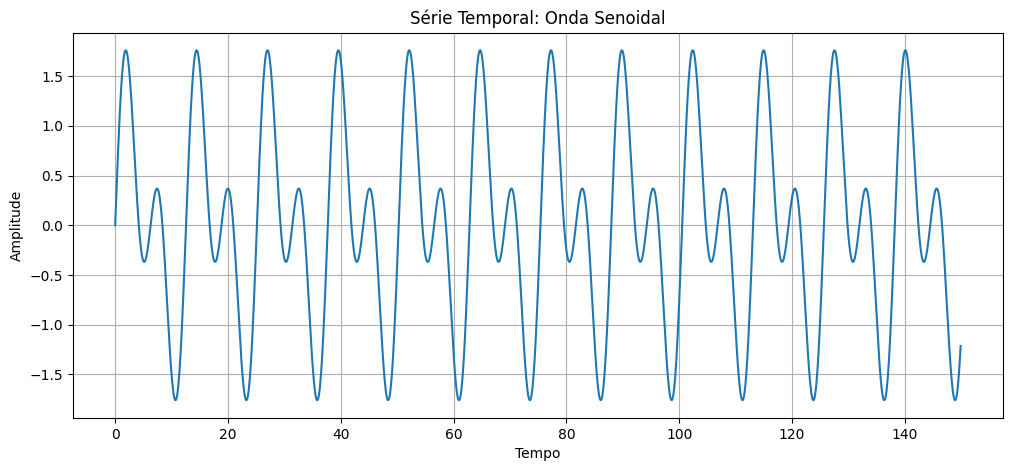

In [11]:
# Gerando uma onda senoidal
t = np.arange(0, 150, 0.1)
amplitude = np.sin(t) + np.sin(t*0.5) # Adicionando complexidade

# Visualizando os dados
plt.figure(figsize=(12, 5))
plt.plot(t, amplitude)
plt.title("Série Temporal: Onda Senoidal")
plt.xlabel("Tempo")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [12]:
# Dividindo em treino e teste
data_scaled = amplitude.reshape(-1, 1) # altera a dimensao de 1D para 2D (Nx1), i.e. uma matriz bidimensional e nao mais um array
train_size = int(len(data_scaled) * 0.70)
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size, :], data_scaled[train_size:len(data_scaled), :]

# Função para criar sequências
# A ideia é usar 'n' passos anteriores (look_back) para prever o próximo passo
def create_sequences(dataset, look_back=10):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20 # Usaremos 20 passos de tempo para prever o 21º
X_train, y_train = create_sequences(train_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)

# As RNNs no Keras esperam a entrada no formato: [amostras, passos_de_tempo, features]
# No nosso caso, o número de features é 1.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Formato de X_train: {X_train.shape}") # (amostras, timesteps, features)
print(f"Formato de y_train: {y_train.shape}")

Formato de X_train: (1029, 20, 1)
Formato de y_train: (1029,)


In [13]:
"""
### Modelo 1: SimpleRNN

Nossa primeira rede terá uma camada `SimpleRNN` e uma camada `Dense` de saída.
"""
tf.random.set_seed(42) # para reprodutibilidade

rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=50, activation='relu', input_shape=(look_back, 1)))
rnn_model.add(Dense(units=1))

rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.summary()

# Treinando o modelo
print("\nTreinando a SimpleRNN...")
history_rnn = rnn_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)


Treinando a SimpleRNN...
Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8688
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5543e-04
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1988e-04
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9115e-04
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9819e-04
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9331e-04
Epoch 9/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7490e-04
Epoch 10/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5037e-04
Epoch 11/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8929e-04
Epoch 12/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4309e-04
Epoch 13/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6996e-05
Epoch 14/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5141e-05
Epoch 15/25
33/

In [14]:
"""
### Modelo 2: LSTM (Long Short-Term Memory)

A LSTM é uma evolução da RNN que usa "portões" (gates) para controlar o fluxo de informação,
o que a ajuda a capturar dependências de longo prazo e evitar o problema de desaparecimento do gradiente.
A estrutura do modelo é a mesma, apenas trocamos a camada.
"""
tf.random.set_seed(42)

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(look_back, 1)))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

# Treinando o modelo
print("\nTreinando a LSTM...")
history_lstm = lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)


Treinando a LSTM...
Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8089
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1467
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0348
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0046
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0017
Epoch 9/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027
Epoch 10/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 11/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.2946e-04
Epoch 12/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1977e-04
Epoch 13/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4698e-04
Epoch 14/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7931e-04
Epoch 15/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9

In [15]:
# Fazendo previsões com ambos os modelos
train_predict_rnn = rnn_model.predict(X_train)
test_predict_rnn = rnn_model.predict(X_test)

train_predict_lstm = lstm_model.predict(X_train)
test_predict_lstm = lstm_model.predict(X_test)

# Invertendo a normalização para a escala original
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_scaled)
train_predict_rnn = scaler.inverse_transform(train_predict_rnn)
test_predict_rnn = scaler.inverse_transform(test_predict_rnn)
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculando o erro
rmse_rnn = np.sqrt(mean_squared_error(y_test_inv, test_predict_rnn))
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, test_predict_lstm))
print(f"\nRMSE da SimpleRNN no teste: {rmse_rnn:.4f}")
print(f"RMSE da LSTM no teste:    {rmse_lstm:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

RMSE da SimpleRNN no teste: 0.0337
RMSE da LSTM no teste:    0.0544


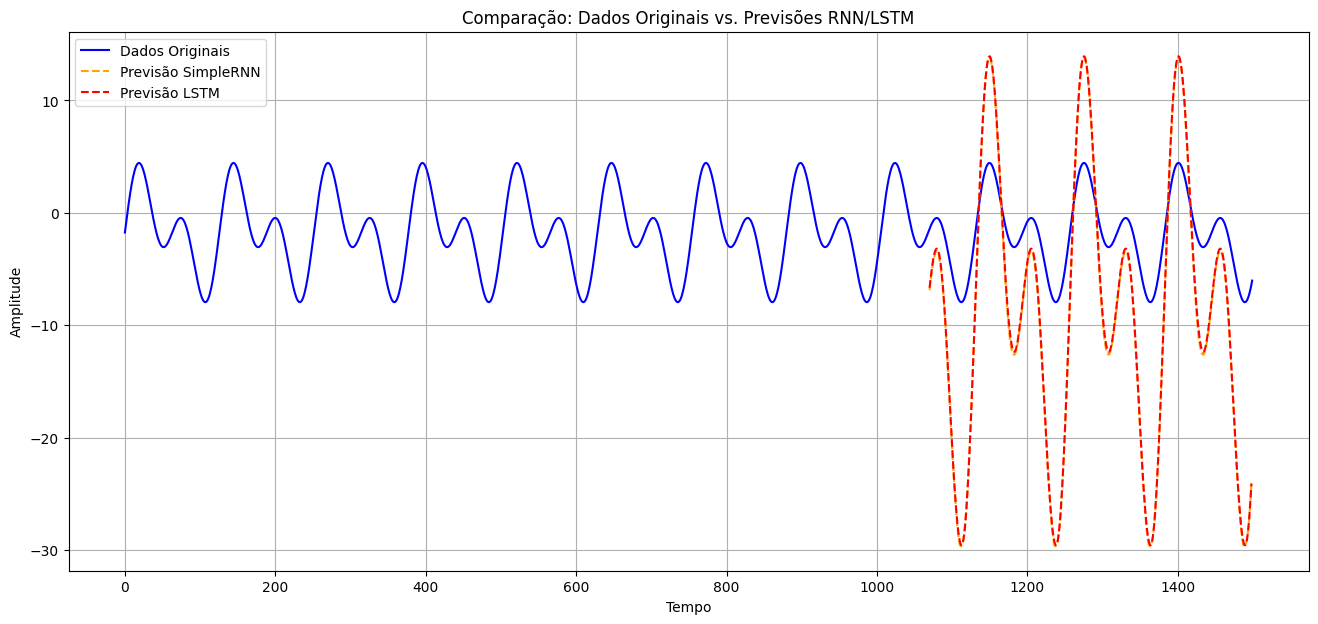

In [17]:

"""
### Visualizando as Previsões

Vamos plotar os dados originais e as previsões dos nossos modelos para ver como eles se saíram.
A linha azul representa os dados reais, enquanto as outras linhas mostram as previsões.
"""
# Criando um array vazio para plotar as previsões na posição correta do eixo X
plot_data = np.empty_like(data_scaled)
plot_data[:, :] = np.nan

# Previsões da RNN
plot_data[len(train_data) + look_back : len(train_data) + look_back + len(test_predict_rnn), :] = test_predict_rnn

# Previsões da LSTM
plot_data_lstm = np.empty_like(data_scaled)
plot_data_lstm[:, :] = np.nan
plot_data_lstm[len(train_data) + look_back : len(train_data) + look_back + len(test_predict_lstm), :] = test_predict_lstm


plt.figure(figsize=(16, 7))
plt.plot(scaler.inverse_transform(data_scaled), label="Dados Originais", color='blue')
plt.plot(scaler.inverse_transform(plot_data), label="Previsão SimpleRNN", color='orange', linestyle='--')
plt.plot(scaler.inverse_transform(plot_data_lstm), label="Previsão LSTM", color='red', linestyle='--')
plt.title("Comparação: Dados Originais vs. Previsões RNN/LSTM")
plt.xlabel("Tempo")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()